In [1]:
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder

### Combine All Raw CSV File

### Data Loading

1. ### Loading CSV files: 
The code starts by loading four separate CSV files containing housing data from different time periods (2000 to 2012, 2012 to 2014, January 2015 to December 2016, and from January 2017 onwards). Each dataset is loaded into a separate DataFrame (data_one, data_two, data_three, data_four).

### Data Cleaning

2. ### Dropping columns: 
For each of the four datasets, it removes the columns block and street_name using the drop method. This is often done to simplify the dataset by removing irrelevant or unnecessary information for the analysis or task at hand.

### Data Combination

3. ### Combining the datasets: 
The cleaned versions of these four datasets are then combined into a single DataFrame called combined_data using pd.concat. The ignore_index=True parameter is used to reindex the combined DataFrame so that the indices go from 0 to n-1 where n is the total number of rows.

### Data Sorting
4. ### Sorting the data: The combined DataFrame is sorted by the month column in ascending order using the sort_values method. This can be useful for time series analysis or when chronological order is important for subsequent operations.

### Handling Missing Data

5. ### Filling missing values:
 Any missing values in the remaining_lease column are filled with the string 'NULL'. This step is crucial to handle null or NaN values which might cause errors during data analysis or modeling.

### Data Transformation

6. ### Extracting and converting data: 
The code extracts the year and month from the month column, which seems to be in the format YYYY-MM. The str.split method is used to separate the year and month into two distinct columns. The expand=True option ensures that the split strings form separate columns, and astype(int) converts these columns from strings to integers. This transformation is helpful for analysis and visualization purposes where you might need to group or filter data by year or month.



In [2]:
data_one = pd.read_csv("data/raw_data/2000to2012.csv")
data_two = pd.read_csv("data/raw_data/2012to2014.csv")
data_three = pd.read_csv("data/raw_data/jan2015toDec2016.csv")
data_four = pd.read_csv("data/raw_data/jan2017upwards.csv")

data_one = data_one.drop(columns=["block", "street_name"])
data_two = data_two.drop(columns=["block", "street_name"])
data_three = data_three.drop(columns=["block", "street_name","remaining_lease"])
data_four = data_four.drop(columns=["block", "street_name","remaining_lease"])

combined_data = pd.concat([data_one, data_two, data_three, data_four], ignore_index=True)

sorted_combined_data = combined_data.sort_values(by='month', ascending=True)

sorted_combined_data

,month,town,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,2000-01,ANG MO KIO,3 ROOM,07 TO 09,69.0,Improved,1986,147000.0
1588,2000-01,QUEENSTOWN,3 ROOM,04 TO 06,66.0,Improved,1970,145000.0
1589,2000-01,QUEENSTOWN,3 ROOM,16 TO 18,72.0,Improved,1970,208000.0
1590,2000-01,QUEENSTOWN,3 ROOM,04 TO 06,72.0,Improved,1970,186000.0
1591,2000-01,QUEENSTOWN,3 ROOM,01 TO 03,72.0,Improved,1970,182000.0
...,...,...,...,...,...,...,...,...
633288,2024-03,HOUGANG,4 ROOM,01 TO 03,105.0,Model A,1990,538888.0
633289,2024-03,HOUGANG,4 ROOM,10 TO 12,91.0,New Generation,1985,538000.0
633290,2024-03,HOUGANG,4 ROOM,07 TO 09,98.0,New Generation,1978,538000.0
633276,2024-03,HOUGANG,4 ROOM,04 TO 06,92.0,Model A,2019,573000.0



1. ### Extracts Column Names:
 Converts the column names of the DataFrame into a list.

2. ### Rearranges Columns: 
Moves the last two columns to the beginning of the DataFrame.

3. ### Applies New Column Order:
 Updates the DataFrame to reflect the new column order.

4. ### Drops a Column: 
Removes the column named "month" from the DataFrame.

5. ### Displays the DataFrame: 
The final state of the DataFrame, now with reordered columns and one less column, is ready for review or further operations.

### This series of operations is typically used to prepare data for analysis by reordering columns for convenience and removing unnecessary data.


In [3]:
cols = sorted_combined_data.columns.tolist()  # Convert column names to a list
cols = cols[-2:] + cols[:-2]
sorted_combined_data = sorted_combined_data[cols]
sorted_combined_data

,lease_commence_date,resale_price,month,town,flat_type,storey_range,floor_area_sqm,flat_model
0,1986,147000.0,2000-01,ANG MO KIO,3 ROOM,07 TO 09,69.0,Improved
1588,1970,145000.0,2000-01,QUEENSTOWN,3 ROOM,04 TO 06,66.0,Improved
1589,1970,208000.0,2000-01,QUEENSTOWN,3 ROOM,16 TO 18,72.0,Improved
1590,1970,186000.0,2000-01,QUEENSTOWN,3 ROOM,04 TO 06,72.0,Improved
1591,1970,182000.0,2000-01,QUEENSTOWN,3 ROOM,01 TO 03,72.0,Improved
...,...,...,...,...,...,...,...,...
633288,1990,538888.0,2024-03,HOUGANG,4 ROOM,01 TO 03,105.0,Model A
633289,1985,538000.0,2024-03,HOUGANG,4 ROOM,10 TO 12,91.0,New Generation
633290,1978,538000.0,2024-03,HOUGANG,4 ROOM,07 TO 09,98.0,New Generation
633276,2019,573000.0,2024-03,HOUGANG,4 ROOM,04 TO 06,92.0,Model A


In [4]:
CPIData = pd.read_csv('data/raw_data/CPID.csv', header=None)

CPIData

,0,1,2,3,4,5,6,7,8,9,...,747,748,749,750,751,752,753,754,755,756
0,DataSeries,2024Jan,2023Sep,2023Oct,2023Nov,2023May,2023Mar,2023Jun,2023Jul,2023Jan,...,1961Oct,1961Nov,1961May,1961Mar,1961Jun,1961Jul,1961Feb,1961Dec,1961Aug,1961Apr
1,All Items,-0.7,0.5,0.2,-0.2,0.3,0.5,0.5,-0.2,0.2,...,0.3,0.2,-0.6,0.1,0.7,0.2,0.1,-0.1,1,-1.6
2,Food,1,0.1,0.2,0.3,0.4,0.4,0,0.2,1.4,...,0.5,0.4,-1,0.2,1.3,0.4,0.1,-0.1,1.8,-3
3,Food Excl Food Serving Services,1.1,0,0.1,0.5,0.8,0.5,-0.4,0.2,1.4,...,na,na,na,na,na,na,na,na,na,na
4,Bread & Cereals,0.6,0.2,1,0.1,0.6,0.6,-0.1,0.2,0.7,...,na,na,na,na,na,na,na,na,na,na
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,Other Personal Effects,1.7,-2.4,0,1.8,0.3,1.2,0.8,-1.4,-0.6,...,na,na,na,na,na,na,na,na,na,na
149,Social Services,0.4,0,0.3,0,0,0,0,-0.1,-1.4,...,na,na,na,na,na,na,na,na,na,na
150,Other Miscellaneous Services,2.9,0,0,0,-0.1,0,0,-1,0.3,...,na,na,na,na,na,na,na,na,na,na
151,All Items Less Imputed Rentals On Owner-Occupi...,-0.9,0.5,0.2,-0.3,0.3,0.5,0.5,-0.4,0.1,...,na,na,na,na,na,na,na,na,na,na


In [5]:
datetoextract = CPIData.iloc[0] 
indextoextract = CPIData.iloc[67]

datetoextract

0      DataSeries
1         2024Jan
2         2023Sep
3         2023Oct
4         2023Nov
          ...    
752       1961Jul
753       1961Feb
754       1961Dec
755       1961Aug
756       1961Apr
Name: 0, Length: 757, dtype: object

In [6]:
data = {'Period': datetoextract, 'CPIvalue': indextoextract}

AccomsCPI = pd.DataFrame(data)

# Extract 'Year' and 'Month' and form the 'Date' column
AccomsCPI[['Year', 'Month']] = AccomsCPI['Period'].str.extract('(\d{4})(\w{3})', expand=True)  
AccomsCPI['Date'] = pd.to_datetime(AccomsCPI['Year'] + AccomsCPI['Month'], format='%Y%b')

# Filter by date and handle missing data
AccomsCPI = AccomsCPI[AccomsCPI['Date'] >= '2000-01-01']
AccomsCPI.loc[AccomsCPI['CPIvalue'] == 'na', 'CPIvalue'] = 0
AccomsCPI.loc[AccomsCPI['CPIvalue'] == None, 'CPIvalue'] = 0

# Convert 'CPIvalue' to float and 'Period' to the appropriate DateTime format
AccomsCPI['CPIvalue'] = AccomsCPI['CPIvalue'].astype(float)
AccomsCPI['Period'] = pd.to_datetime(AccomsCPI['Period'], format='%Y%b').dt.to_period('M')
AccomsCPI = AccomsCPI.sort_values('Period', ascending=False)

# Info and final adjustments
AccomsCPI = AccomsCPI[['Period', 'CPIvalue']]  # Reorder and select necessary columns
AccomsCPI = AccomsCPI.reset_index(drop=True)

AccomsCPI

,Period,CPIvalue
0,2024-01,-2.7
1,2023-12,0.2
2,2023-11,1.9
3,2023-10,-1.4
4,2023-09,0.3
...,...,...
284,2000-05,0.0
285,2000-04,0.0
286,2000-03,0.0
287,2000-02,0.0


In [7]:
AccomsCPI['AdjustmentValue'] = 1.0

# Loop to calculate AdjustmentValue
for idx in AccomsCPI.index:
    if idx != 0:
        prev_adjustment_value = AccomsCPI.at[idx - 1, 'AdjustmentValue']
        cur_cpi_value = AccomsCPI.at[idx, 'CPIvalue']

        AccomsCPI.at[idx, 'AdjustmentValue'] = prev_adjustment_value * (1 + (cur_cpi_value/100))


# Converting Period to string
AccomsCPI['Period'] = AccomsCPI['Period'].astype(str)

AccomsCPI

,Period,CPIvalue,AdjustmentValue
0,2024-01,-2.7,1.000000
1,2023-12,0.2,1.002000
2,2023-11,1.9,1.021038
3,2023-10,-1.4,1.006743
4,2023-09,0.3,1.009764
...,...,...,...
284,2000-05,0.0,1.491176
285,2000-04,0.0,1.491176
286,2000-03,0.0,1.491176
287,2000-02,0.0,1.491176


### The code uses the Seaborn library to create a line plot that visualizes changes in "AdjustmentValue" over the years from a DataFrame called AccomsCPI. 
* ### Function: 
Uses sb.lineplot to draw a line plot.

* ### Data Source: 
The data for the plot is taken from the AccomsCPI DataFrame.

* ### X-axis:
 Plots the 'Year' column as the x-axis.

* ### Y-axis: 
Uses the 'AdjustmentValue' column for the y-axis.

### This visualization is effective for examining how the adjustment values have trended over time, which can provide insights into economic or financial trends reflected in the data. The plot is assigned to the variable ax, allowing for further customization or analysis.

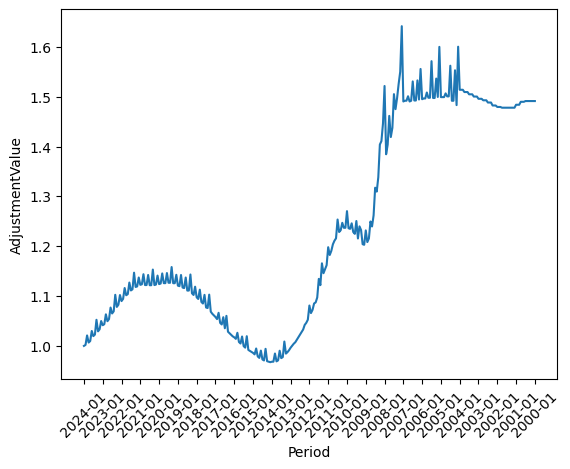

In [8]:
ax = sb.lineplot(data=AccomsCPI,x="Period",y="AdjustmentValue")
ax.set_xticks(range(0, len(AccomsCPI), 12))  
ax.set_xticklabels([AccomsCPI['Period'][i] for i in range(0, len(AccomsCPI), 12)], rotation=45) 

plt.show()


### The code performs the following key operations on two pandas DataFrames:

### Merge Data:
 It merges sorted_combined_data and AccomsCPI based on common columns 'Year' and 'Month'. This effectively combines the data from both frames where there is a match in both year and month, providing a unified view.

### Handle Missing Values:
 After merging, it fills any missing entries in the 'AdjustmentValue' column with the string "NA", ensuring there are no NaN values which could disrupt further data processing or analysis.

### Display the DataFrame: 
The merged and modified DataFrame is presented, allowing for review or further operations.

### This approach is useful for integrating and cleaning data in preparation for detailed analysis or reporting where consistent data format across all rows is critical.

### The code performs several operations on a DataFrame called merged_data to refine and enhance its usability for analysis:

### Adjust Resale Prices:
 It calculates an adjusted resale price based on historical CPI adjustments to reflect current value.

### Clean Up: 
It removes unnecessary columns like 'CPIvalue' after their use, streamlining the DataFrame.

### Lease Calculation:
 It transforms the 'remaining_lease' information from a textual format into a numerical value in years for easier analysis, by extracting years and months and converting them into a single decimal value.

### Storey Calculation: 
It calculates the average storey for listings by extracting and averaging numerical values from a range provided in the 'storey_range' column.

### Final Cleanup:
 It drops several now-redundant columns including original storey information, the old resale price, and the adjustment value used earlier.

### Handle Missing Data: 
It ensures any missing values in 'remaining_lease' are clearly marked as NaN, helping maintain data integrity for operations that are sensitive to missing values.

### These transformations make the data more analytically friendly, facilitating deeper and more accurate data analysis by converting textual and complex data into structured numerical formats.


In [9]:
merged_data = pd.merge(sorted_combined_data, AccomsCPI, left_on='month', right_on='Period', how='left')

merged_data['Year'] = merged_data['month'].str.split('-').str[0].astype(int)
merged_data['Month'] = merged_data['month'].str.split('-').str[1].astype(int)

#Adjusting to today's value
merged_data['resale_price_adjusted'] = merged_data['resale_price'] * merged_data['AdjustmentValue'].fillna(1)

#changing 7 to 9 floor into average of 8th floor
merged_data['lower_storey'] = merged_data['storey_range'].str.extract(r'(\d+) TO (\d+)').astype(float).iloc[:,0]
merged_data['upper_storey'] = merged_data['storey_range'].str.extract(r'(\d+) TO (\d+)').astype(float).iloc[:,1]
merged_data['average_storey'] = (merged_data['lower_storey'] + merged_data['upper_storey']) / 2

merged_data = merged_data[['Year', 'Month', 'lease_commence_date', 'floor_area_sqm', 'average_storey', 'town', 'flat_type', 'flat_model', 'resale_price_adjusted']]

merged_data.head(100)

,Year,Month,lease_commence_date,floor_area_sqm,average_storey,town,flat_type,flat_model,resale_price_adjusted
0,2000,1,1986,69.0,8.0,ANG MO KIO,3 ROOM,Improved,219202.861724
1,2000,1,1970,66.0,5.0,QUEENSTOWN,3 ROOM,Improved,216220.509864
2,2000,1,1970,72.0,17.0,QUEENSTOWN,3 ROOM,Improved,310164.593460
3,2000,1,1970,72.0,5.0,QUEENSTOWN,3 ROOM,Improved,277358.722998
4,2000,1,1970,72.0,2.0,QUEENSTOWN,3 ROOM,Improved,271394.019278
...,...,...,...,...,...,...,...,...,...
95,2000,1,1996,126.0,5.0,PASIR RIS,5 ROOM,Improved,574102.733088
96,2000,1,1996,126.0,11.0,PASIR RIS,5 ROOM,Improved,582304.200703
97,2000,1,1996,126.0,14.0,PASIR RIS,5 ROOM,Improved,630767.418431
98,2000,1,1996,127.0,11.0,PASIR RIS,5 ROOM,Improved,562173.325647



### The code provided uses Seaborn, a data visualization library, to create boxen plots for a subset of data related to property resale values. Here’s a concise overview of what the code accomplishes:

### Data Preparation:
 A new DataFrame is created focusing on four key attributes: 'town', 'flat_type', 'flat_model', and 'resale_price_adjusted'. This streamlined DataFrame isolates the necessary data for visualization.

### Visualization Loop: 
The code iterates through the categorical columns 'town', 'flat_type', and 'flat_model'. For each category, a visualization process is carried out.

### FacetGrid Setup: 
A FacetGrid is configured for each category, facilitating individual plots for each categorical variable without shared axes, which allows each plot to independently scale and display its data.

### Boxen Plot Creation: 
Boxen plots are generated to visually represent the distribution of 'resale_price_adjusted' within each category. These plots provide a detailed look at the quantiles, which is more informative than traditional box plots, especially useful for larger datasets.

### Plot Customization:
 The plots are enhanced for readability by adjusting label sizes, rotating x-axis labels for clarity, and ensuring the layout fits all elements neatly.

### This sequence of operations effectively visualizes how various housing characteristics influence adjusted resale prices, offering insights into market trends and helping in data-driven decision-making.

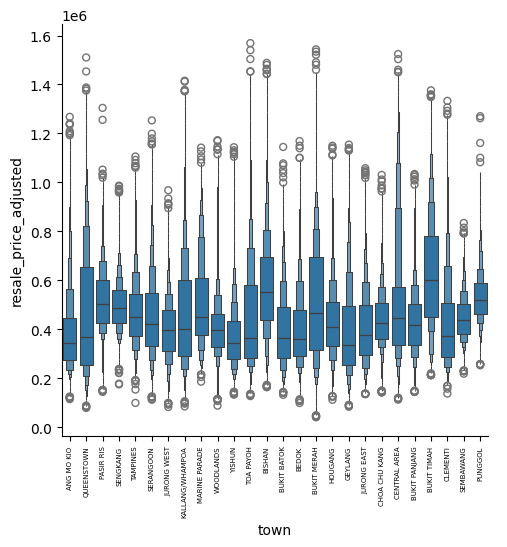

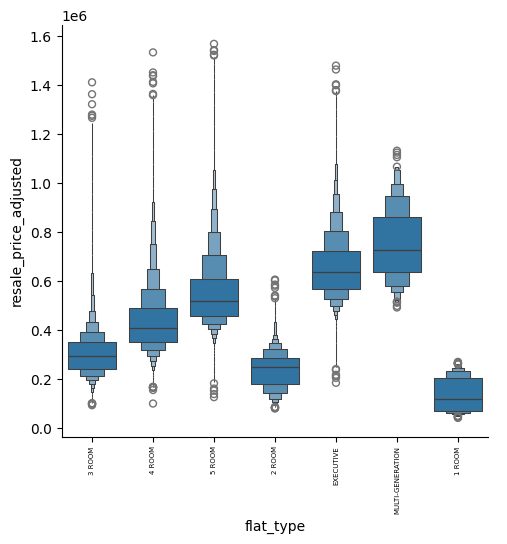

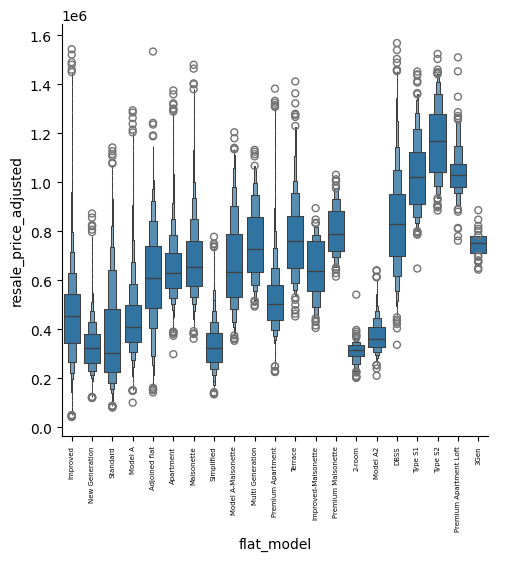

In [10]:
for column in ['town','flat_type','flat_model']:
    plot = sb.catplot(data=merged_data, x=column, y='resale_price_adjusted', kind = 'boxen')
    plot.set_xticklabels(fontsize=5,rotation = 90)  


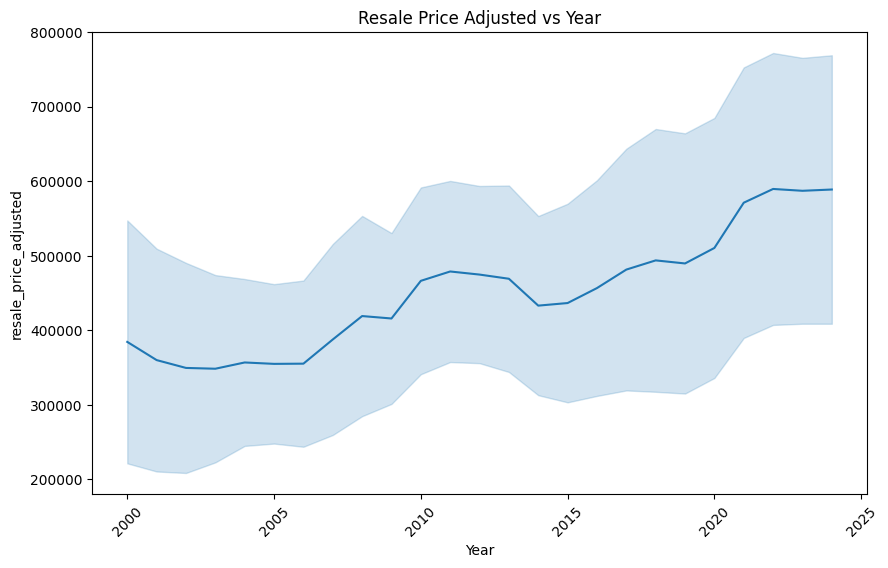

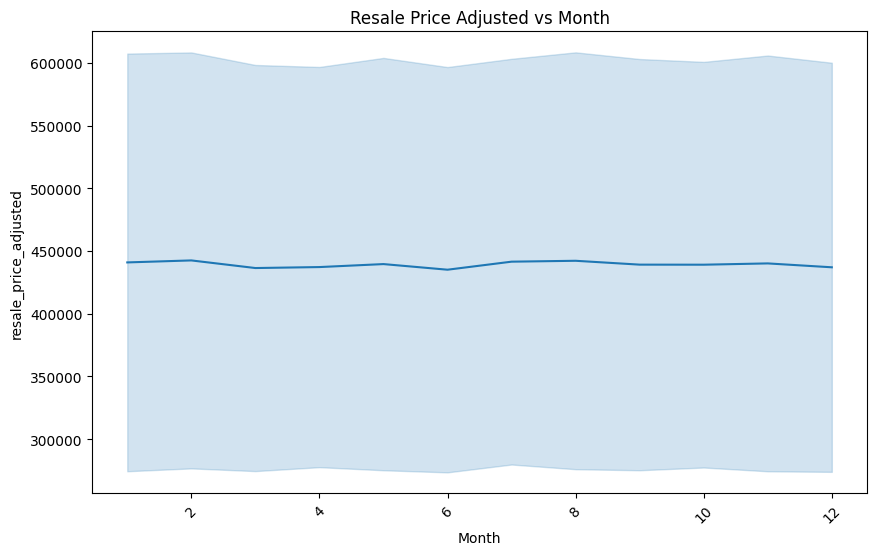

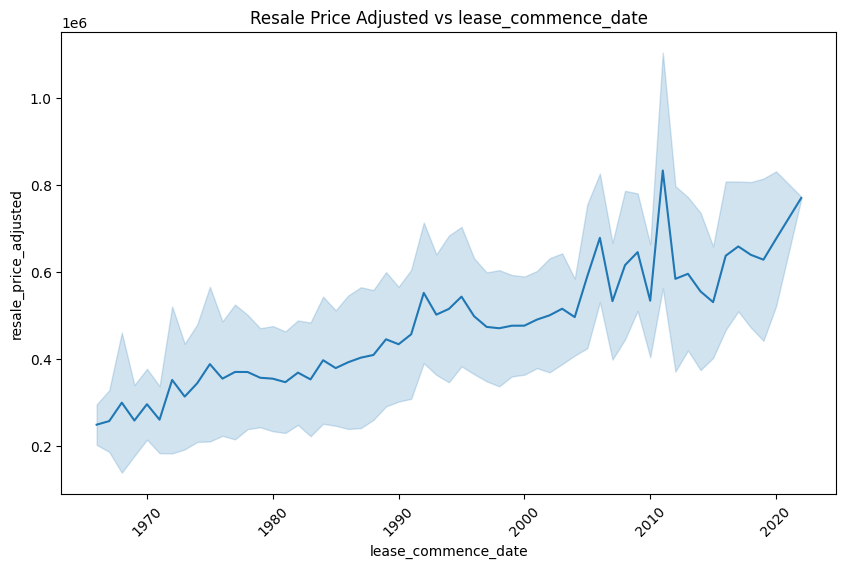

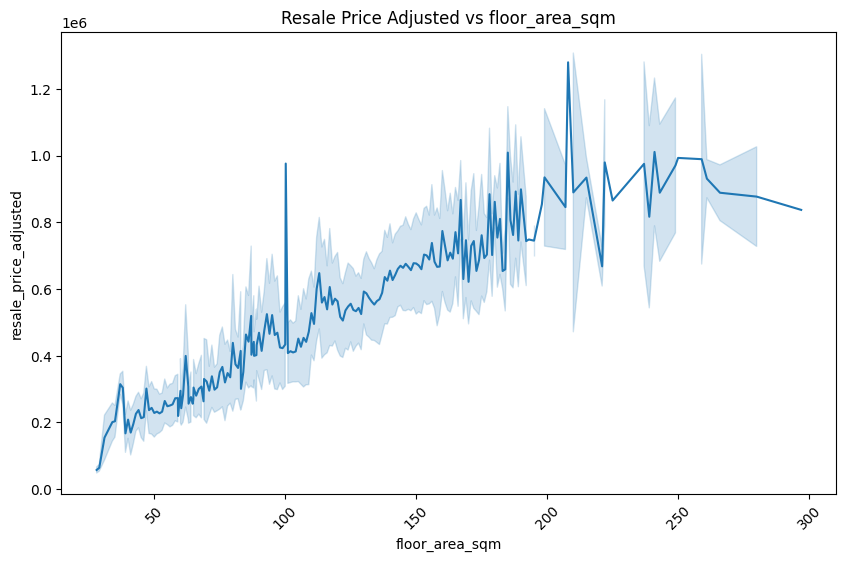

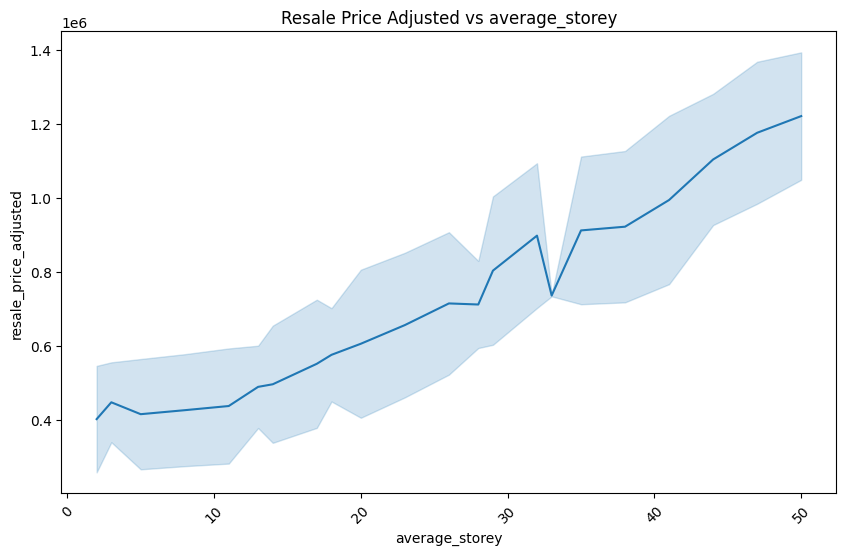

In [11]:
for column in ['Year', 'Month', 'lease_commence_date', 'floor_area_sqm', 'average_storey']:
    plt.figure(figsize=(10, 6))  
    plot = sb.lineplot(data=merged_data, x=column, y='resale_price_adjusted',errorbar = 'sd')
    plt.title(f'Resale Price Adjusted vs {column}')  
    plt.xticks(rotation=45)  
    plt.show()  


### The code is for visualizing trends in adjusted resale prices over time using pandas and Seaborn, structured by individual years. Here's a concise summary of its functions:

### Creating a Date Column:
 It combines 'Year' and 'Month' data into a new 'date' column, standardizing it to the first day of each month for consistent plotting.

### Setting Up FacetGrid: 
Constructs a grid of line plots with one plot per year, wrapping the grid every five years to create an organized display, each with independent scaling on both axes.

### Mapping Data to Plots: 
Each subplot shows the trend of adjusted resale prices over months within a specific year, using a line plot for clear trend visualization.

### Formatting and Labeling:
 The x-axis labels are formatted to show abbreviated month names, enhancing readability, and axis labels are set to clarify the plotted data.

### Layout Adjustment and Display: 
Adjusts the layout to prevent overlap and display the full plot cleanly.

### his approach provides a detailed and comparative visualization of how resale prices, adjusted for economic factors, fluctuate monthly and vary annually, aiding in data analysis or reporting.

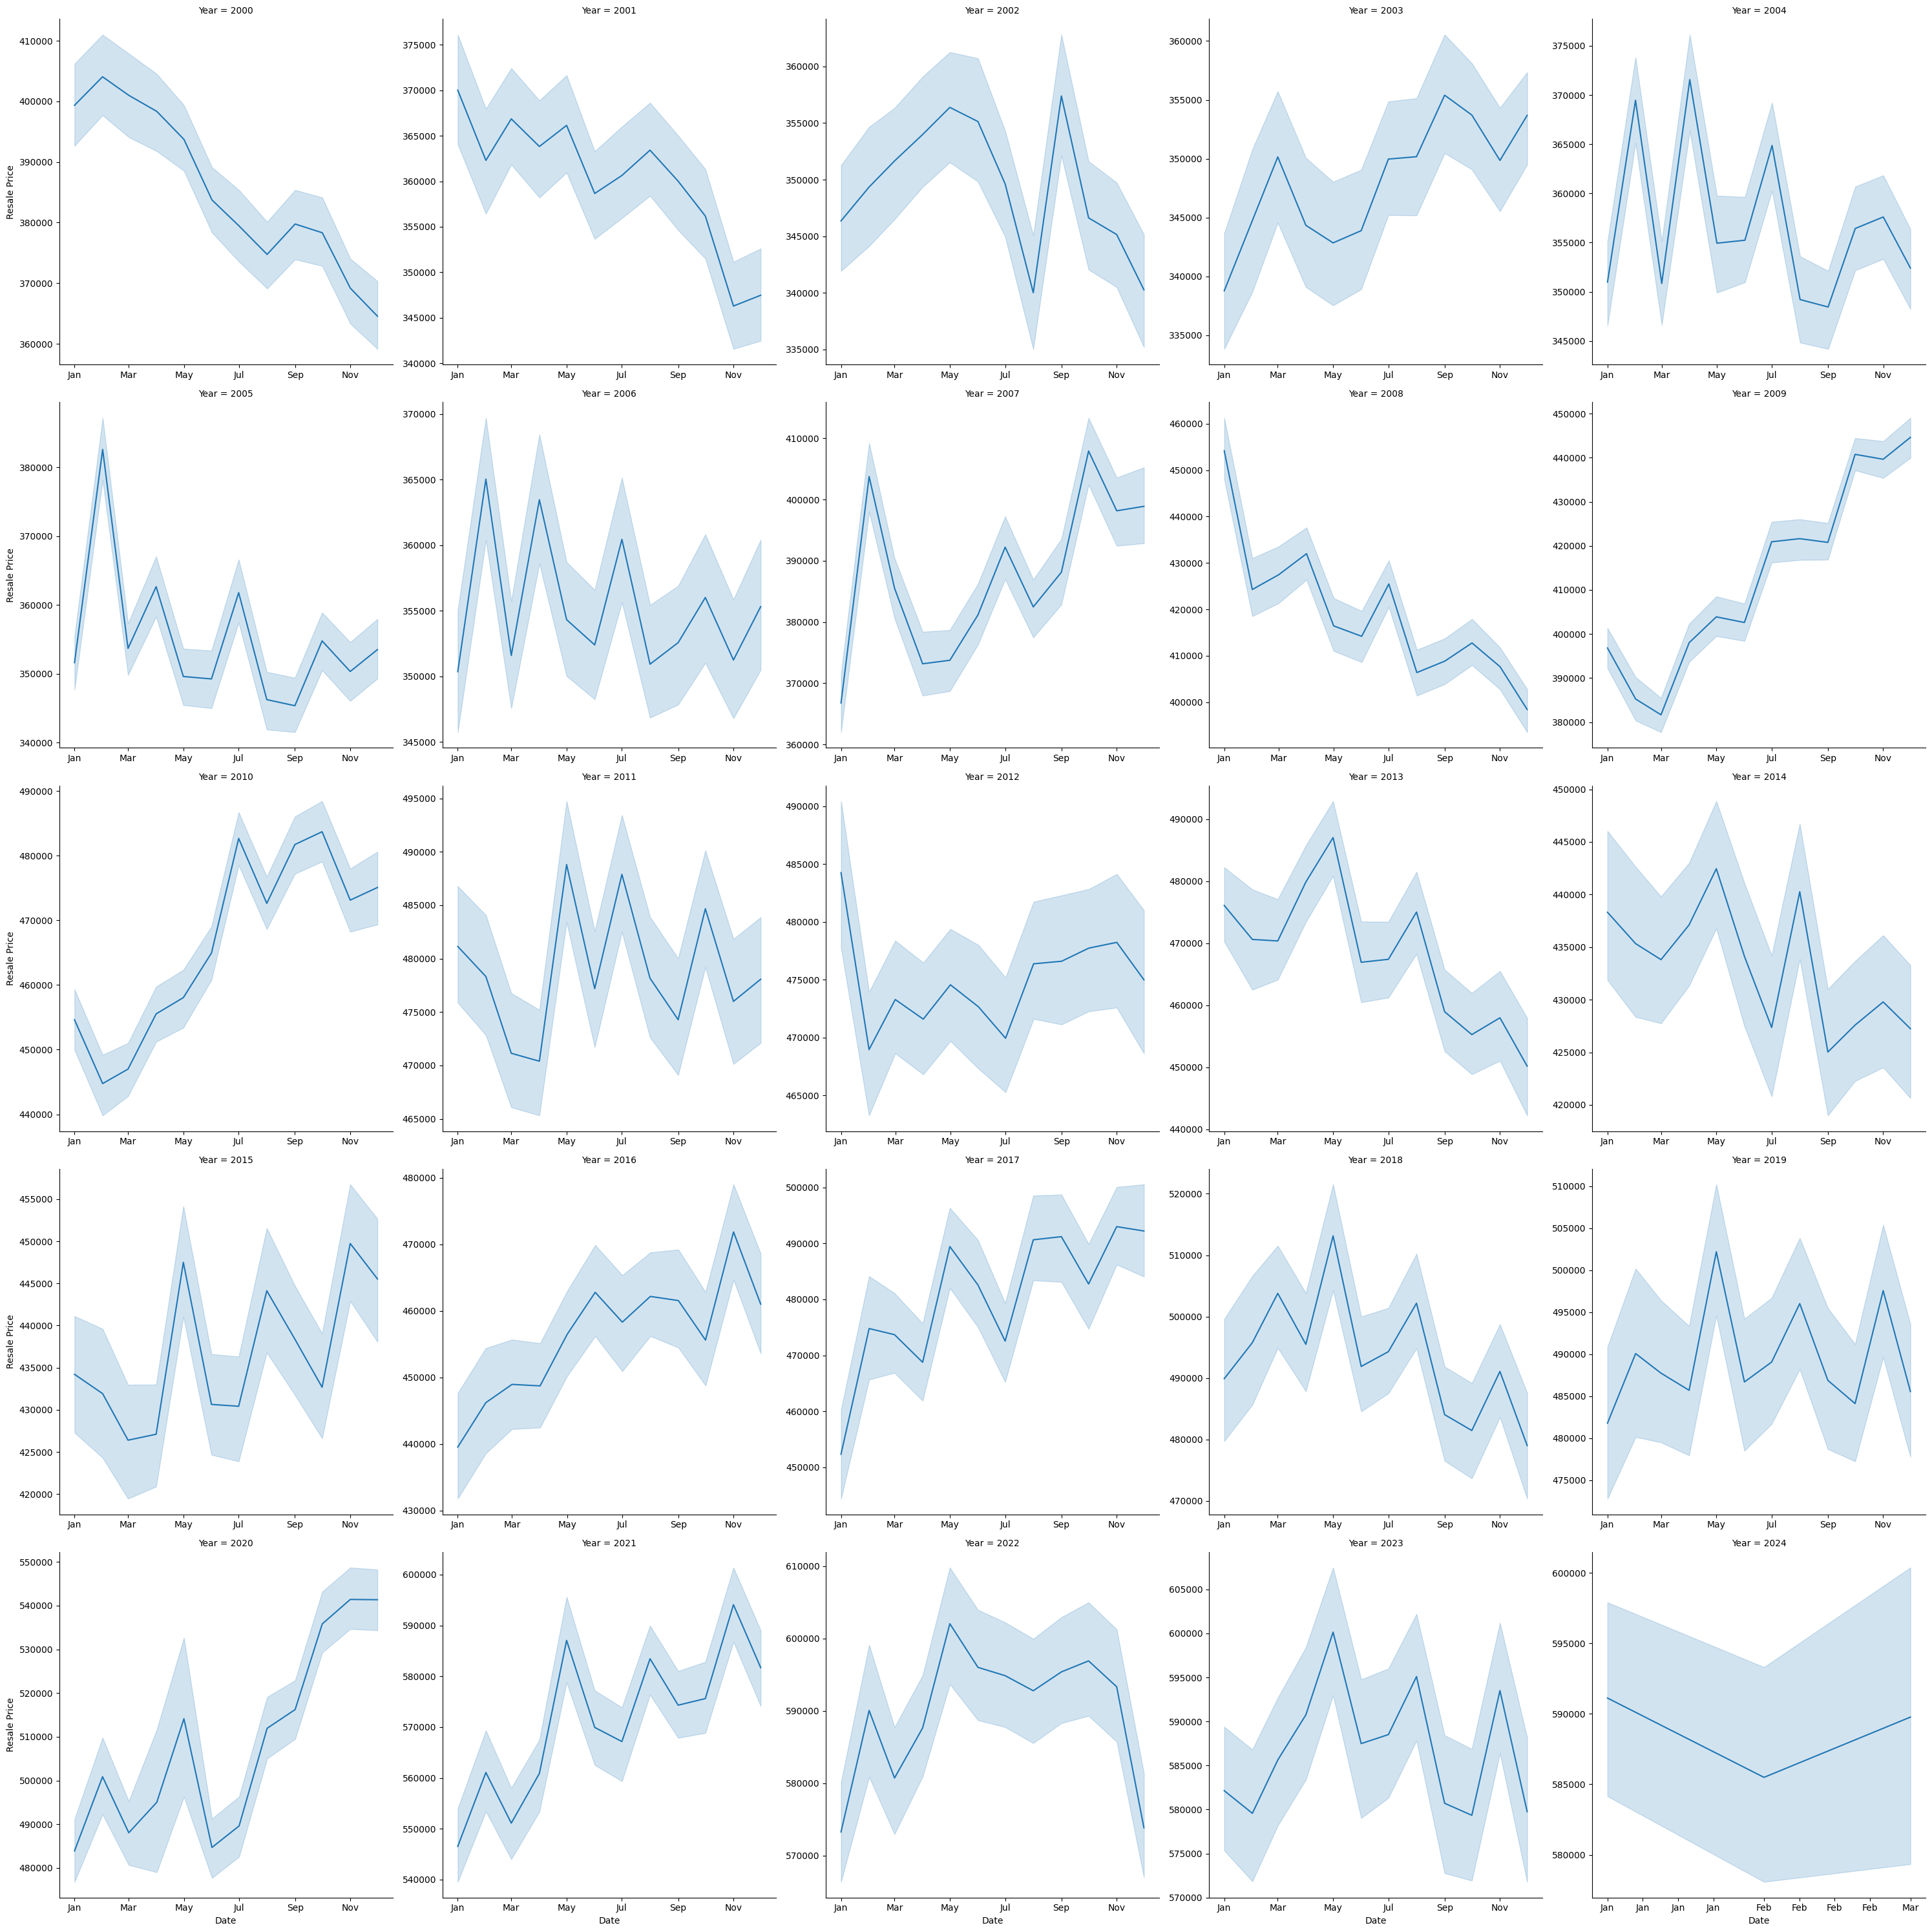

In [12]:
merged_data['date'] = pd.to_datetime(merged_data[['Year', 'Month']].assign(day=1))

g = sb.FacetGrid(merged_data, col="Year", col_wrap=5, height=6,sharex=False, sharey=False)
g.map(sb.lineplot, "date", "resale_price_adjusted")
g.set_axis_labels("Date", "Resale Price")

for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()
plt.show()

### The provided code defines three dictionaries that map textual descriptions of Singapore housing data to numerical identifiers, which is a common preprocessing step in data analysis and machine learning. Each dictionary serves a specific category:

### area_dict: 
Associates names of different areas or neighborhoods with unique integer codes, useful for identifying and analyzing regional housing trends.

### model_type_dict: 
Maps various flat models, like 'Model A', 'Standard', etc., to numbers, categorizing flats based on their architectural designs or layouts.

### flat_type_dict:
 Converts descriptions of flats, primarily based on room count such as '5 ROOM', 'EXECUTIVE', etc., into numeric codes, which simplifies size and capacity comparisons.

### These encodings transform categorical text data into a numeric format, enhancing the efficiency and effectiveness of statistical analysis or machine learning models that require numeric inputs.

In [13]:
merged_data = merged_data.drop(columns = ['date'])
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634002 entries, 0 to 634001
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Year                   634002 non-null  int64  
 1   Month                  634002 non-null  int64  
 2   lease_commence_date    634002 non-null  int64  
 3   floor_area_sqm         634002 non-null  float64
 4   average_storey         634002 non-null  float64
 5   town                   634002 non-null  object 
 6   flat_type              634002 non-null  object 
 7   flat_model             634002 non-null  object 
 8   resale_price_adjusted  634002 non-null  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 43.5+ MB


In [14]:
encoding_mappings = {}

numerical_data = merged_data.select_dtypes(include=['float64', 'int64','int32'])
categorical_columns = merged_data.select_dtypes(include=['object']).columns.tolist()

encoded_data = merged_data.copy()
for column in categorical_columns:

    mean_prices = merged_data.groupby(column)['resale_price_adjusted'].median().sort_values()
    rank = {category: rank for rank, category in enumerate(mean_prices.index, 0)}
    
    encoding_mappings[column] = rank
    encoded_data[column] = merged_data[column].map(rank)

final_data = pd.concat([numerical_data, encoded_data[categorical_columns]], axis=1)

final_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634002 entries, 0 to 634001
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Year                   634002 non-null  int64  
 1   Month                  634002 non-null  int64  
 2   lease_commence_date    634002 non-null  int64  
 3   floor_area_sqm         634002 non-null  float64
 4   average_storey         634002 non-null  float64
 5   resale_price_adjusted  634002 non-null  float64
 6   town                   634002 non-null  int64  
 7   flat_type              634002 non-null  int64  
 8   flat_model             634002 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 43.5 MB


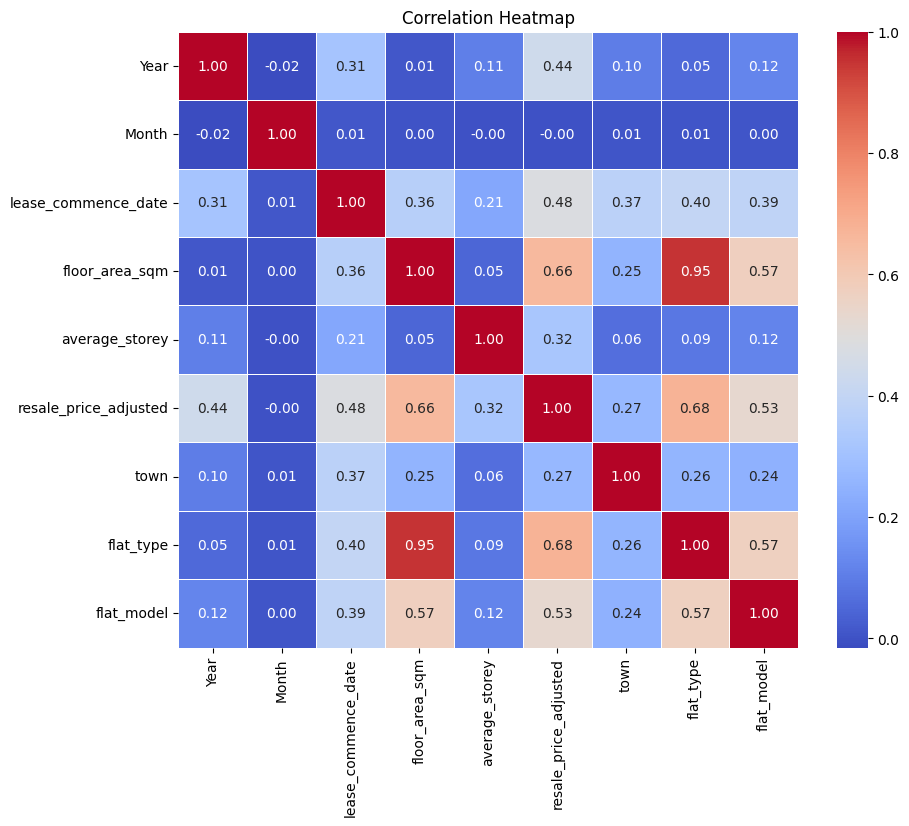

In [15]:
corr = final_data.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sb.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.xticks(rotation=90)  

plt.show()

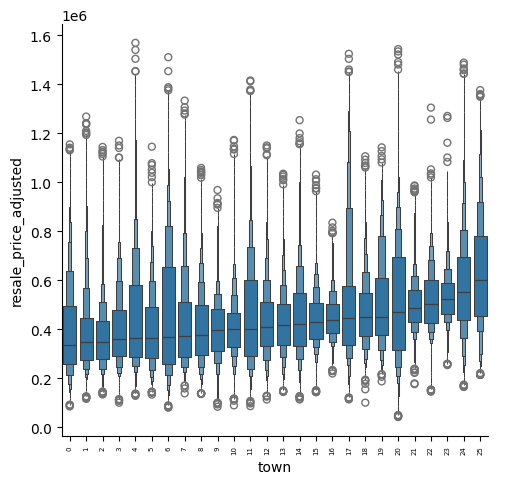

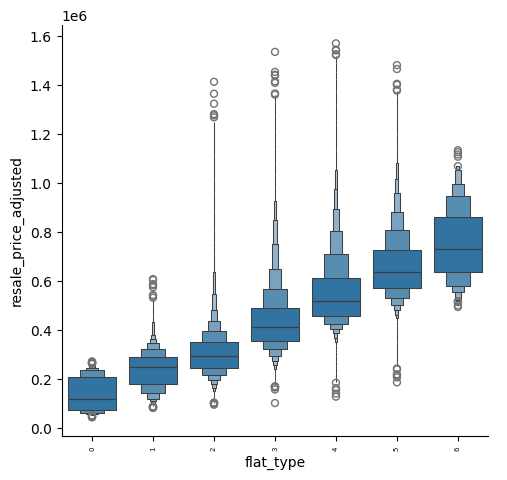

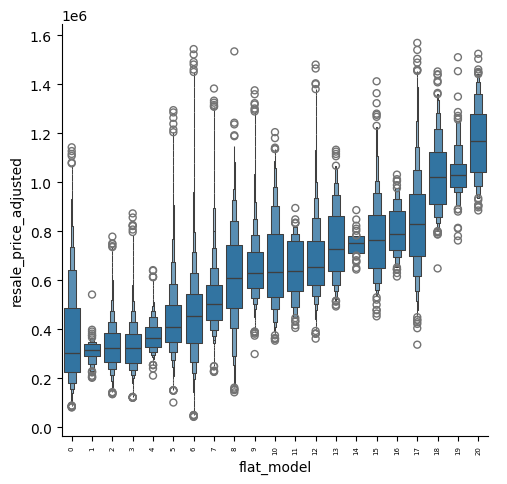

In [16]:
for column in ['town','flat_type','flat_model']:
    plot = sb.catplot(data=final_data, x=column, y='resale_price_adjusted', kind = 'boxen')
    plot.set_xticklabels(fontsize=5,rotation = 90)  

In [17]:
for category, mappings in encoding_mappings.items():
    print(f"{category}:")
    for key, value in mappings.items():
        print(f"  {key}: {value}")
    print() 

town:
  GEYLANG: 0
  ANG MO KIO: 1
  YISHUN: 2
  BEDOK: 3
  TOA PAYOH: 4
  BUKIT BATOK: 5
  QUEENSTOWN: 6
  CLEMENTI: 7
  JURONG EAST: 8
  JURONG WEST: 9
  WOODLANDS: 10
  KALLANG/WHAMPOA: 11
  HOUGANG: 12
  BUKIT PANJANG: 13
  SERANGOON: 14
  CHOA CHU KANG: 15
  SEMBAWANG: 16
  CENTRAL AREA: 17
  TAMPINES: 18
  MARINE PARADE: 19
  BUKIT MERAH: 20
  SENGKANG: 21
  PASIR RIS: 22
  PUNGGOL: 23
  BISHAN: 24
  BUKIT TIMAH: 25

flat_type:
  1 ROOM: 0
  2 ROOM: 1
  3 ROOM: 2
  4 ROOM: 3
  5 ROOM: 4
  EXECUTIVE: 5
  MULTI-GENERATION: 6

flat_model:
  Standard: 0
  2-room: 1
  Simplified: 2
  New Generation: 3
  Model A2: 4
  Model A: 5
  Improved: 6
  Premium Apartment: 7
  Adjoined flat: 8
  Apartment: 9
  Model A-Maisonette: 10
  Improved-Maisonette: 11
  Maisonette: 12
  Multi Generation: 13
  3Gen: 14
  Terrace: 15
  Premium Maisonette: 16
  DBSS: 17
  Type S1: 18
  Premium Apartment Loft: 19
  Type S2: 20



<Axes: xlabel='Year', ylabel='resale_price_adjusted'>

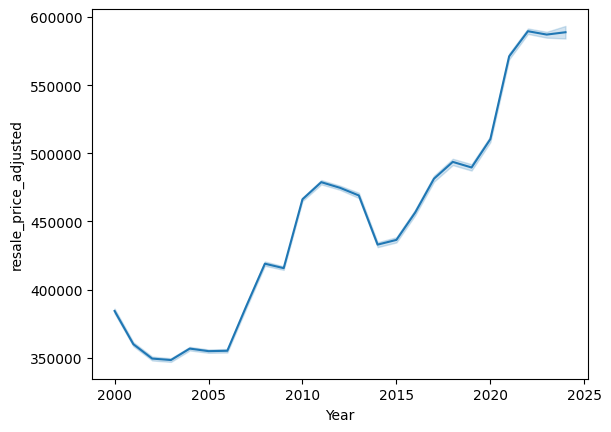

In [18]:
sb.lineplot(data = final_data, x='Year', y = 'resale_price_adjusted')

floor_area_sqm           0.295712
lease_commence_date      0.374158
resale_price_adjusted    1.003236
average_storey           1.425422
town                     0.178356
flat_type                0.319618
flat_model               1.121342
dtype: float64


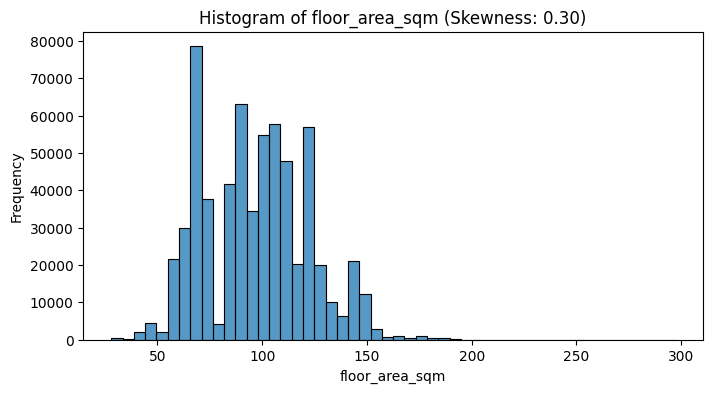

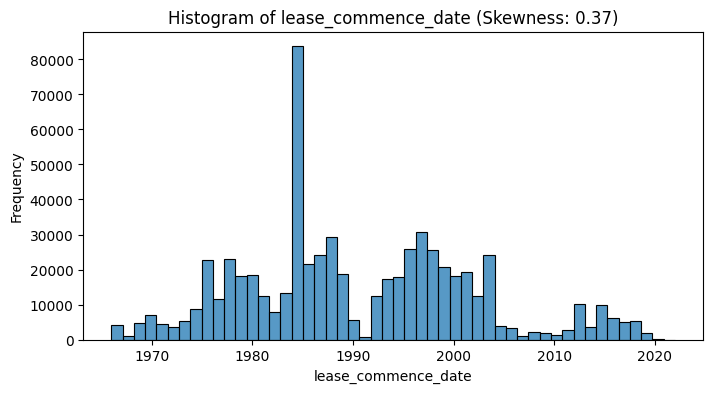

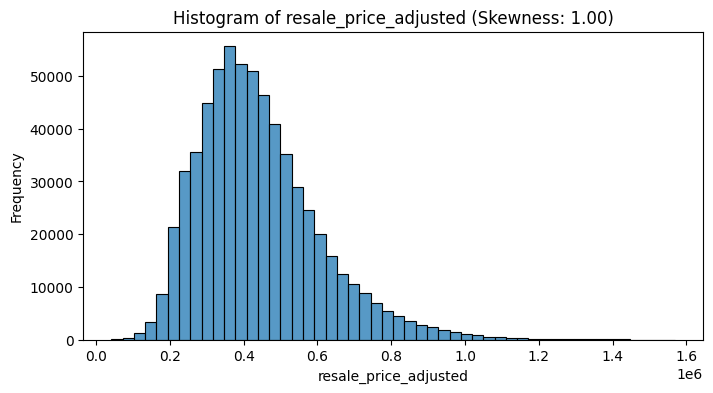

In [19]:
skewness_values = final_data[['floor_area_sqm', 'lease_commence_date','resale_price_adjusted','average_storey','town','flat_type','flat_model']].skew()

# Print the skewness value for each column
print(skewness_values)

columns = ['floor_area_sqm', 'lease_commence_date','resale_price_adjusted']

for col in columns:
    plt.figure(figsize=(8, 4))
    sb.histplot(final_data[col],bins=50, kde=False)
    plt.title(f'Histogram of {col} (Skewness: {skewness_values[col]:.2f})')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [20]:
# final_data['log_resale_price_adjusted'] = np.log(final_data['resale_price_adjusted'])

final_data = final_data.drop(columns='Month')

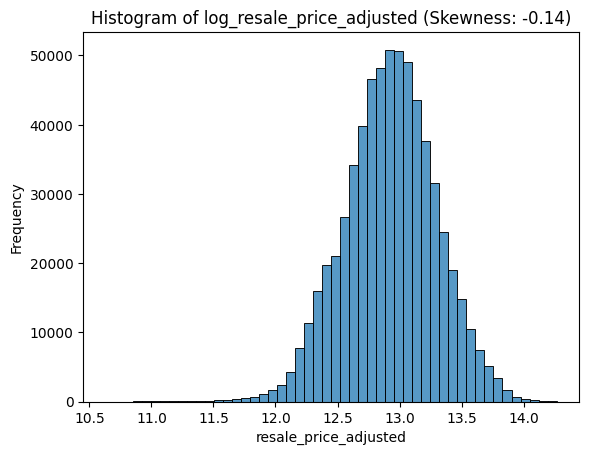

In [21]:
sb.histplot(np.log(final_data['resale_price_adjusted']),bins=50, kde=False)
skewness_value = np.log(final_data['resale_price_adjusted']).skew()
plt.title(f'Histogram of log_resale_price_adjusted (Skewness: {skewness_value:.2f})')
plt.xlabel(col)
plt.ylabel('Frequency')
plt.show()

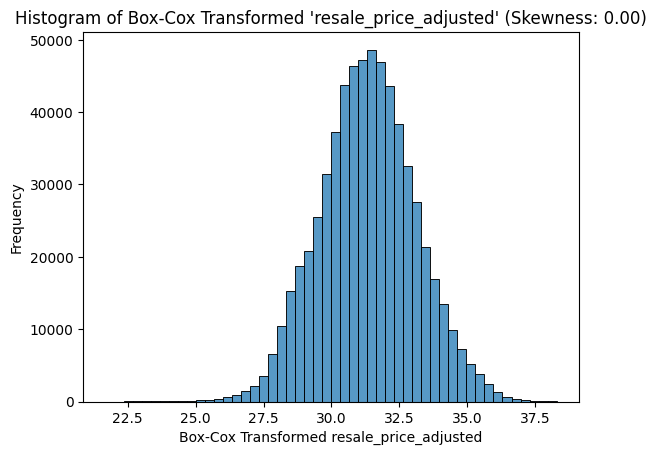

In [22]:
from scipy import stats

# Apply the Box-Cox transformation
resale_price_adjusted_boxcox, _ = stats.boxcox(final_data['resale_price_adjusted'])

# Plot the histogram of the Box-Cox transformed data
sb.histplot(resale_price_adjusted_boxcox, bins=50, kde=False)

# Calculate the skewness after Box-Cox transformation
skewness_value_boxcox = pd.Series(resale_price_adjusted_boxcox).skew()

# Title, xlabel, and ylabel for the plot
plt.title(f'Histogram of Box-Cox Transformed \'resale_price_adjusted\' (Skewness: {skewness_value_boxcox:.2f})')
plt.xlabel('Box-Cox Transformed resale_price_adjusted')
plt.ylabel('Frequency')

# Display the plot
plt.show()

In [23]:
final_data.to_csv('data/clean_data/final_data.csv',index=False)

In [24]:
import json

with open('data/clean_data/encoding_mappings.json', 'w') as fp:
    json.dump(encoding_mappings, fp)